In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import nbinom

warnings.filterwarnings("ignore")

## Synthetic gene expression generation

In [141]:
# Parameters
n_cells = 10000
n_genes = 20
target_zero_prob = 0.8  # Desired overall zero probability

# Simulate gene-specific parameters
np.random.seed(42)
mu_values = np.random.uniform(1, 10, n_genes)         # Mean of NB
theta_values = np.random.uniform(0.5, 2.0, n_genes)   # Dispersion 

# Initialize gene expression matrix
x = np.zeros((n_cells, n_genes), dtype=int)

pi_values = []
# Fill the matrix with ZINB simulated data, solving for pi to match target zero probability
for j in range(n_genes):
    mu = mu_values[j]
    r = 1 / theta_values[j]  

    # Scipy-compatible NB probability
    p = r / (r + mu)

    # Compute probability of zero from NB
    p_nb_zero = nbinom.pmf(0, r, p)

    # Solve for pi to match target overall zero probability
    pi = (target_zero_prob - p_nb_zero) / (1 - p_nb_zero)
    pi = np.clip(pi, 0, 1)  # Ensure it's within [0,1]
    pi_values.append(pi)

    # Simulate NB samples
    nb_samples = nbinom.rvs(r, p, size=n_cells)

    # Apply zero-inflation
    zero_mask = np.random.binomial(1, pi, size=n_cells)
    nb_samples[zero_mask == 1] = 0

    x[:, j] = nb_samples

pi_values = np.array(pi_values)


# Check actual zero proportion
actual_zero_rate = (x == 0).sum() / x.size
print(f"Actual overall zero proportion: {actual_zero_rate:.4f}")

Actual overall zero proportion: 0.7997


In [142]:
from scipy.stats import nbinom
import numpy as np

def create_combination_gene(x, gene_indices, 
                            target_zero_prob=0.8,
                            transformation='sum',
                            fixed_dispersion=0.01):
    """
    Create a synthetic gene using NB + zero-inflation, from a function of other genes.

    Parameters:
    - x: (n_cells, n_genes) original gene expression matrix
    - gene_indices: list of gene indices to combine
    - target_zero_prob: desired zero-inflation level
    - transformation: how to combine input genes
    - fixed_dispersion: θ (smaller = less overdispersion)

    Returns:
    - g_combo: synthetic gene expression (ZINB-sampled)
    - mu_combo, theta_combo, pi_combo
    """
    subset = x[:, gene_indices]

    if transformation == 'sum':
        combined_activity = subset.sum(axis=1)
    elif transformation == 'mean':
        combined_activity = subset.mean(axis=1)
    elif transformation == 'prod':
        combined_activity = np.prod(subset + 1, axis=1)  # avoid zeroing
    elif transformation == 'tanh':
        combined_activity = np.tanh(subset.sum(axis=1) / len(gene_indices))
    elif transformation == 'logsum':
        combined_activity = np.log1p(subset.sum(axis=1))
    else:
        raise ValueError("Unsupported transformation")

    mu_combo = np.clip(combined_activity.mean(), 1, 40)
    theta_combo = fixed_dispersion
    r = 1 / theta_combo
    p = r / (r + mu_combo)

    # Compute NB zero prob, then solve for π
    p_nb_zero = nbinom.pmf(0, r, p)
    pi_combo = (target_zero_prob - p_nb_zero) / (1 - p_nb_zero)
    pi_combo = np.clip(pi_combo, 0, 1)

    nb_samples = nbinom.rvs(r, p, size=x.shape[0])
    zero_mask = np.random.binomial(1, pi_combo, size=x.shape[0])
    nb_samples[zero_mask == 1] = 0

    return nb_samples, mu_combo, theta_combo, pi_combo


In [143]:
def generate_ZINB_combinations(x, transformations, k=3, target_zero_prob=0.8, fixed_dispersion=0.01, seed=42):
    """
    Generate ZINB-sampled synthetic genes using random gene subsets and transformations.

    Parameters:
    - x: expression matrix (n_cells, n_genes)
    - transformations: list of transformation types
    - k: number of genes to combine per synthetic gene
    - target_zero_prob: target zero-inflation for ZINB
    - fixed_dispersion: NB dispersion (θ)
    - seed: reproducibility

    Returns:
    - x_combo: synthetic gene matrix (n_cells, len(transformations)+1)
    - metadata: list of dicts with transformation + gene_indices + ZINB params
    """
    np.random.seed(seed)
    n_genes = x.shape[1]

    combo_genes = []
    metadata = []

    for transform in transformations:
        gene_indices = np.random.choice(n_genes, size=k, replace=False).tolist()

        g_combo, mu, theta, pi = create_combination_gene(
            x,
            gene_indices=gene_indices,
            transformation=transform,
            target_zero_prob=target_zero_prob,
            fixed_dispersion=fixed_dispersion
        )

        combo_genes.append(g_combo)
        metadata.append({
            'transformation': transform,
            'gene_indices': gene_indices,
            'mu': mu,
            'theta': theta,
            'pi': pi
        })

    # Create "combo of combos" (mean of synthetic genes), also ZINB-sampled
    combo_matrix = np.column_stack(combo_genes)
    meta_gene_indices = list(range(len(transformations)))

    g_meta, mu_meta, theta_meta, pi_meta = create_combination_gene(
        combo_matrix,
        gene_indices=meta_gene_indices,
        transformation='mean',
        target_zero_prob=target_zero_prob,
        fixed_dispersion=fixed_dispersion
    )

    combo_genes.append(g_meta)
    metadata.append({
        'transformation': 'mean (combo of combos)',
        'gene_indices': meta_gene_indices,
        'mu': mu_meta,
        'theta': theta_meta,
        'pi': pi_meta
    })

    x_combo = np.column_stack(combo_genes)
    return x_combo, metadata


In [144]:
transformations = ['sum', 'mean', 'prod', 'tanh', 'logsum']
x_combo, metadata = generate_ZINB_combinations(
    x=x,
    transformations=transformations,
    k=3,
    target_zero_prob=0.8,
    fixed_dispersion=0.01,
    seed=42
)

metadata

[{'transformation': 'sum',
  'gene_indices': [0, 17, 15],
  'mu': np.float64(3.2981),
  'theta': 0.01,
  'pi': np.float64(0.7918892470139154)},
 {'transformation': 'mean',
  'gene_indices': [11, 17, 1],
  'mu': np.float64(1.7818666666666667),
  'theta': 0.01,
  'pi': np.float64(0.7587497459403909)},
 {'transformation': 'prod',
  'gene_indices': [2, 10, 15],
  'mu': np.float64(7.8267),
  'theta': 0.01,
  'pi': np.float64(0.7998931854338023)},
 {'transformation': 'tanh',
  'gene_indices': [12, 7, 13],
  'mu': np.float64(1.0),
  'theta': 0.01,
  'pi': np.float64(0.68268513749219)},
 {'transformation': 'logsum',
  'gene_indices': [5, 16, 12],
  'mu': np.float64(1.0),
  'theta': 0.01,
  'pi': np.float64(0.68268513749219)},
 {'transformation': 'mean (combo of combos)',
  'gene_indices': [0, 1, 2, 3, 4],
  'mu': np.float64(1.0),
  'theta': 0.01,
  'pi': np.float64(0.68268513749219)}]

In [145]:
mu_new = [m['mu'] for m in metadata]
theta_new = [m['theta'] for m in metadata]
pi_new = [m['pi'] for m in metadata]

mu_values = np.concatenate([mu_values, mu_new])
theta_values = np.concatenate([theta_values, theta_new])
pi_values = np.concatenate([pi_values, pi_new])


In [147]:
np.hstack([x, x_combo]).shape

(10000, 26)

In [148]:
x = np.hstack([x, x_combo])

## Architecture and loss definition

In [149]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ----------------------------
# ZINB LOSS FUNCTION
# ----------------------------
class ZINBLoss(nn.Module):
    def __init__(self, ridge_lambda=0.0):
        super(ZINBLoss, self).__init__()
        self.eps = 1e-10
        self.ridge_lambda = ridge_lambda

    def forward(self, x, mean, dispersion, pi, scale_factor=1.0):
        x = x.float()
        mean = mean * scale_factor

        nb_case = (
            torch.lgamma(dispersion + self.eps)
            + torch.lgamma(x + 1.0)
            - torch.lgamma(x + dispersion + self.eps)
            - dispersion * torch.log(dispersion + self.eps)
            - x * torch.log(mean + self.eps)
            + (dispersion + x) * torch.log(dispersion + mean + self.eps)
        )

        zero_case = -torch.log(pi + ((1.0 - pi) * torch.exp(-nb_case)) + self.eps)

        result = torch.where(torch.lt(x, 1e-8), zero_case, -torch.log(1.0 - pi + self.eps) + nb_case)
        ridge = self.ridge_lambda * (pi ** 2).sum()

        return result.mean() + ridge


# ----------------------------
# ENCODER
# ----------------------------
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


# ----------------------------
# DECODER (Conditional on Batch)
# ----------------------------
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, output_dim)
        self.fc_disp = nn.Linear(hidden_dim, output_dim)
        self.fc_pi = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        mean = F.relu(self.fc_mean(h))
        dispersion = F.relu(self.fc_disp(h))
        pi = torch.sigmoid(self.fc_pi(h))
        return mean, dispersion, pi


# ----------------------------
# VAE MODULE
# ----------------------------
class ZINBVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(ZINBVAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
        self.zinb_loss_fn = ZINBLoss()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        mean, disp, pi = self.decoder(z)
        return mean, disp, pi, mu, logvar, z

    def loss_function(self, x, mean, disp, pi, mu, logvar):
        zinb_loss = self.zinb_loss_fn(x, mean, disp, pi)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        return zinb_loss + 1e-3 * kl_div


## Set seed and training loop

No dataloader for simplicity

In [150]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For deterministic behavior
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False



In [151]:
true_mu_tensor = torch.tensor(np.tile(mu_values, (n_cells, 1)) , dtype=torch.float32)
true_theta_tensor = torch.tensor(np.tile(theta_values, (n_cells, 1)), dtype=torch.float32)
true_pi_tensor = torch.tensor(np.tile(pi_values, (n_cells, 1)), dtype=torch.float32)

In [152]:
# Set the seed
set_seed(11)
vae = ZINBVAE(input_dim=x.shape[1], hidden_dim=30, latent_dim=5)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
x = torch.tensor(x, dtype=torch.float32)

vae.train()
for epoch in range(1000):
    optimizer.zero_grad()
    mean, disp, pi, mu, logvar, z = vae(x)
    loss = vae.loss_function(x, mean, disp, pi, mu, logvar)
    loss.backward()
    optimizer.step()
    #print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    
    with torch.no_grad():
        mean_mse = F.mse_loss(mean, true_mu_tensor).item()
        theta_mse = F.mse_loss(disp, true_theta_tensor).item()
        pi_mse = F.mse_loss(pi, true_pi_tensor).item()

        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Mean MSE: {mean_mse:.4f}, Theta MSE: {theta_mse:.4f}, Pi MSE: {pi_mse:.4f}")
    

Epoch 0, Loss: 9.5316, Mean MSE: 29.6395, Theta MSE: 3.6563, Pi MSE: 0.0675
Epoch 1, Loss: 9.1132, Mean MSE: 29.2583, Theta MSE: 2.5292, Pi MSE: 0.0686
Epoch 2, Loss: 8.6636, Mean MSE: 27.8524, Theta MSE: 2.4065, Pi MSE: 0.0699
Epoch 3, Loss: 8.3044, Mean MSE: 38.3821, Theta MSE: 10.4333, Pi MSE: 0.0709
Epoch 4, Loss: 8.0214, Mean MSE: 27.4543, Theta MSE: 1.2031, Pi MSE: 0.0725
Epoch 5, Loss: 7.7571, Mean MSE: 27.5649, Theta MSE: 1.2371, Pi MSE: 0.0737
Epoch 6, Loss: 7.5487, Mean MSE: 27.1075, Theta MSE: 1.0413, Pi MSE: 0.0751
Epoch 7, Loss: 7.0731, Mean MSE: 27.4788, Theta MSE: 1.6266, Pi MSE: 0.0769
Epoch 8, Loss: 6.9621, Mean MSE: 27.3167, Theta MSE: 1.3961, Pi MSE: 0.0780
Epoch 9, Loss: 6.8173, Mean MSE: 26.9230, Theta MSE: 1.0662, Pi MSE: 0.0794
Epoch 10, Loss: 6.4609, Mean MSE: 27.2132, Theta MSE: 1.3483, Pi MSE: 0.0809
Epoch 11, Loss: 6.3503, Mean MSE: 26.8390, Theta MSE: 1.0880, Pi MSE: 0.0824
Epoch 12, Loss: 6.0710, Mean MSE: 27.8742, Theta MSE: 1.6920, Pi MSE: 0.0841
Epoch 13

In [153]:
x = x.detach().numpy()
x

array([[ 0.,  0.,  0., ...,  0.,  4.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 7.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  3.,  0.],
       [ 6.,  0.,  3., ...,  0.,  2.,  0.],
       [ 0., 11.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [154]:
w = 2
[x[0][0] + w*t for t in range(20)]

[np.float32(0.0),
 np.float32(2.0),
 np.float32(4.0),
 np.float32(6.0),
 np.float32(8.0),
 np.float32(10.0),
 np.float32(12.0),
 np.float32(14.0),
 np.float32(16.0),
 np.float32(18.0),
 np.float32(20.0),
 np.float32(22.0),
 np.float32(24.0),
 np.float32(26.0),
 np.float32(28.0),
 np.float32(30.0),
 np.float32(32.0),
 np.float32(34.0),
 np.float32(36.0),
 np.float32(38.0)]

In [155]:
x00_perturbed = x[0].copy()
x00_perturbed = np.tile(x00_perturbed, (20, 1))
x00_perturbed[:, 0] = [x[0][0] + w*t for t in range(20)]
x00_perturbed[:, 0]

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30., 32., 34., 36., 38.], dtype=float32)

In [156]:
metadata[0]["gene_indices"]

[0, 17, 15]

In [157]:
x00_perturbed[:,metadata[0]["gene_indices"]].shape

(20, 3)

In [160]:
x00_perturbed = x[0].copy()
x00_perturbed = np.tile(x00_perturbed, (20, 1))
x00_perturbed[:, 0] = [x[0][0] + w*t for t in range(20)]
x00_perturbed[:, 0]

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30., 32., 34., 36., 38.], dtype=float32)

In [159]:
x00_perturbed = torch.tensor(x00_perturbed, dtype=torch.float32)

In [ ]:
x00_perturbed 

torch.Size([20, 26])

In [ ]:
mean_perturbed[:,20].shape

torch.Size([20])

In [164]:
x00_perturbed[:,20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [162]:
ground_truth_sum

tensor([ 0.0000,  0.6667,  1.3333,  2.0000,  2.6667,  3.3333,  4.0000,  4.6667,
         5.3333,  6.0000,  6.6667,  7.3333,  8.0000,  8.6667,  9.3333, 10.0000,
        10.6667, 11.3333, 12.0000, 12.6667])

In [113]:
ground_truth_sum = x00_perturbed[:,metadata[0]["gene_indices"]].mean(axis=1)
ground_truth_sum.shape

torch.Size([20])

In [91]:
x00_perturbed.shape

torch.Size([20, 26])

In [95]:
# Set the seed
set_seed(11)

vae.eval()
with torch.no_grad():
    optimizer.zero_grad()
    mean_perturbed, disp, pi, mu, logvar, z = vae(x00_perturbed)
    #loss = vae.loss_function(x, mean, disp, pi, mu, logvar)
    #print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    #mean_mse = F.mse_loss(mean, true_mu_tensor).item()
    #theta_mse = F.mse_loss(disp, true_theta_tensor).item()
    #pi_mse = F.mse_loss(pi, true_pi_tensor).item()

    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 999, Loss: 0.9769


In [ ]:
x00_perturbed = x00_perturbed.detach().numpy()

In [115]:
mean_perturbed_gene = mean_perturbed[:,20].detach().numpy()

In [168]:
ground_truth_sum = x00_perturbed[:,metadata[0]["gene_indices"]].sum(axis=1)
ground_truth_sum.shape

(20,)

In [117]:
ground_truth_sum.shape

torch.Size([20])

In [118]:
x00_perturbed.shape

torch.Size([20, 26])

In [170]:
np.mean((mean_perturbed_gene - ground_truth_sum)**2)

np.float32(326.51068)

In [135]:
np.min(true_mu_tensor[:,20].numpy())


np.float32(3.2981)

In [167]:
true_mu_tensor[:,20]

tensor([3.2981, 3.2981, 3.2981,  ..., 3.2981, 3.2981, 3.2981])

In [139]:
true_mu_tensor[:,21]

tensor([1.7819, 1.7819, 1.7819,  ..., 1.7819, 1.7819, 1.7819])

In [136]:
np.max(true_mu_tensor[:,20].numpy())

np.float32(3.2981)

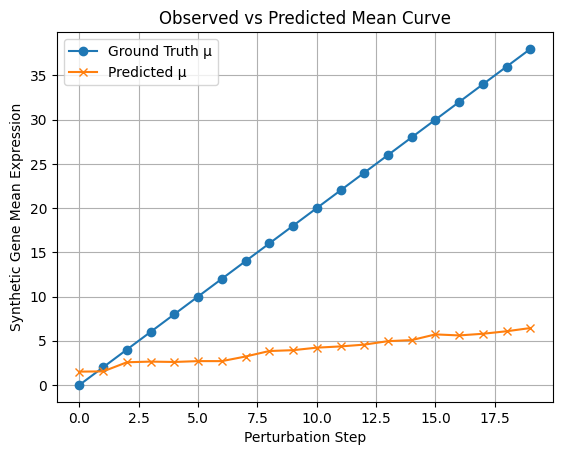

In [171]:
import matplotlib.pyplot as plt

plt.plot(ground_truth_sum, label="Ground Truth μ", marker="o")
plt.plot(mean_perturbed_gene, label="Predicted μ", marker="x")
plt.xlabel("Perturbation Step")
plt.ylabel("Synthetic Gene Mean Expression")
plt.title("Observed vs Predicted Mean Curve")
plt.legend()
plt.grid(True)
plt.show()


In [51]:
adata.obsm["z"] = z.detach().numpy()
adata.obsm["mean"] = mean.detach().numpy()
adata.obsm["dispersion"] = disp.detach().numpy()
adata.obsm["pi"] = pi.detach().numpy()

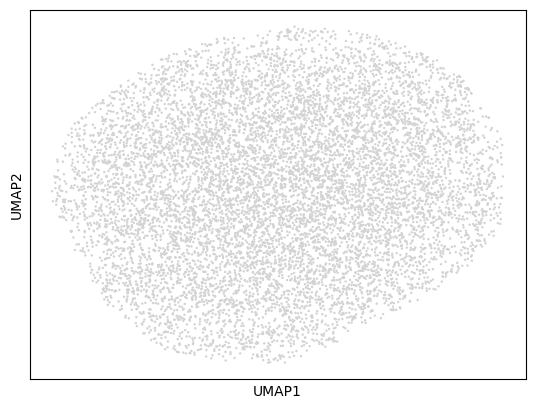

In [53]:
sc.pp.neighbors(adata, use_rep="z")
sc.tl.umap(adata)
sc.pl.umap(adata)

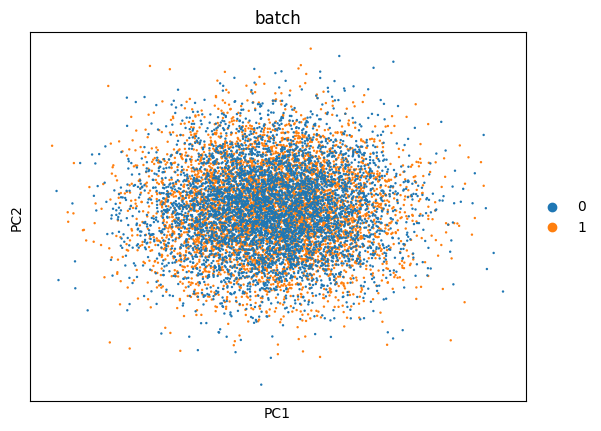

In [96]:
adata_test = sc.AnnData(X=z.detach().numpy())
adata_test.obs["batch"] = adata.obs["batch"]
sc.tl.pca(adata_test)
sc.pl.pca(adata_test, color='batch')

In [97]:
"""import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(x.sum(1), label='Input', color='blue', stat='density', kde=True, bins=50, alpha=0.5)
sns.histplot(adata.obsm["zinb_output"].sum(1), label='Decoder Output', color='orange', stat='density', kde=True, bins=50, alpha=0.5)
plt.xlabel("Total Counts per Cell")
plt.ylabel("Density")
plt.title("Distribution of Total Counts per Cell")
plt.legend()
plt.tight_layout()
plt.show()
"""

'import seaborn as sns\n\nplt.figure(figsize=(8, 5))\nsns.histplot(x.sum(1), label=\'Input\', color=\'blue\', stat=\'density\', kde=True, bins=50, alpha=0.5)\nsns.histplot(adata.obsm["zinb_output"].sum(1), label=\'Decoder Output\', color=\'orange\', stat=\'density\', kde=True, bins=50, alpha=0.5)\nplt.xlabel("Total Counts per Cell")\nplt.ylabel("Density")\nplt.title("Distribution of Total Counts per Cell")\nplt.legend()\nplt.tight_layout()\nplt.show()\n'

In [98]:
def sample_zinb(mean, disp, pi, eps=1e-8):
    """
    Sample counts from a Zero-Inflated Negative Binomial distribution.

    Parameters:
        mean: Tensor [n_cells, n_genes]
        disp: Tensor [n_cells, n_genes]
        pi:   Tensor [n_cells, n_genes]

    Returns:
        samples: Tensor [n_cells, n_genes]
    """
    # Ensure tensors are on the same device
    mean, disp, pi = mean.to(torch.float32), disp.to(torch.float32), pi.to(torch.float32)

    # Compute NB parameters
    p = mean / (mean + disp + eps)  # success probability
    r = disp  # number of failures

    # Gamma-Poisson sampling trick for NB
    gamma_sample = torch._standard_gamma(r)
    nb_sample = torch.poisson(gamma_sample * (p / (1 - p + eps)))

    # Apply zero inflation
    keep_mask = torch.bernoulli(1.0 - pi)  # 1 = keep, 0 = zero-inflate
    zinb_sample = nb_sample * keep_mask

    return zinb_sample

set_seed(11)
zinb_sample = sample_zinb(mean, disp, pi)
zinb_sample

tensor([[15.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 4., 50.,  0.,  ...,  7.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  8.,  5.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])

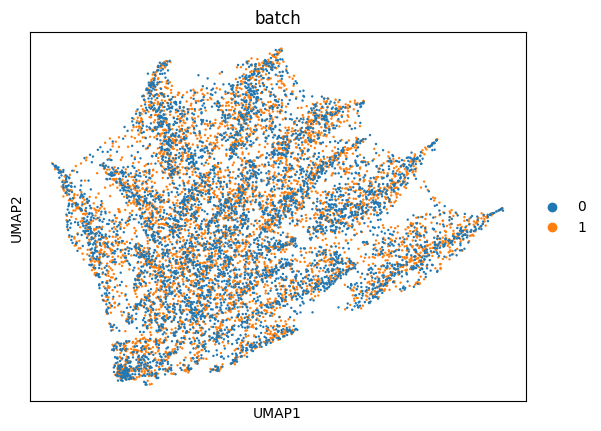

In [99]:
adata.obsm["zinb_sample"] = zinb_sample.detach().numpy()

sc.pp.neighbors(adata, use_rep="zinb_sample")
sc.tl.umap(adata)
sc.pl.umap(adata, color='batch')


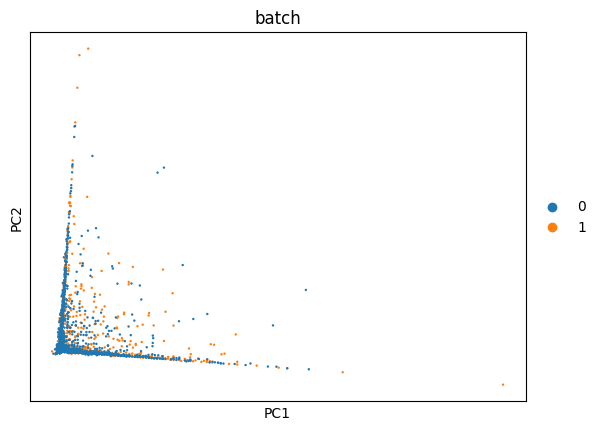

In [100]:
adata_test = sc.AnnData(X=zinb_sample.detach().numpy())
adata_test.obs["batch"] = adata.obs["batch"]
sc.tl.pca(adata_test)
sc.pl.pca(adata_test, color='batch', layer="z")

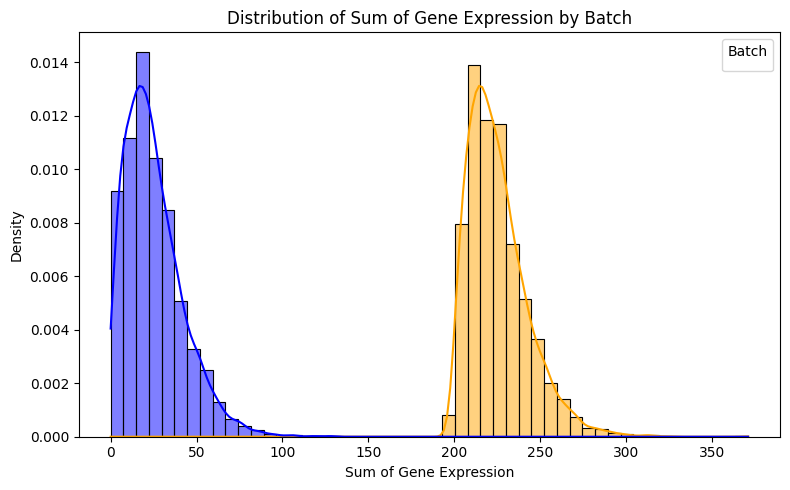

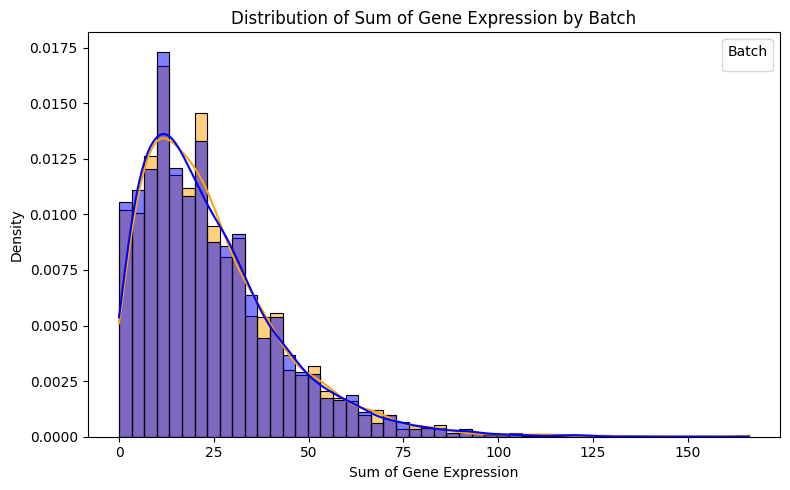

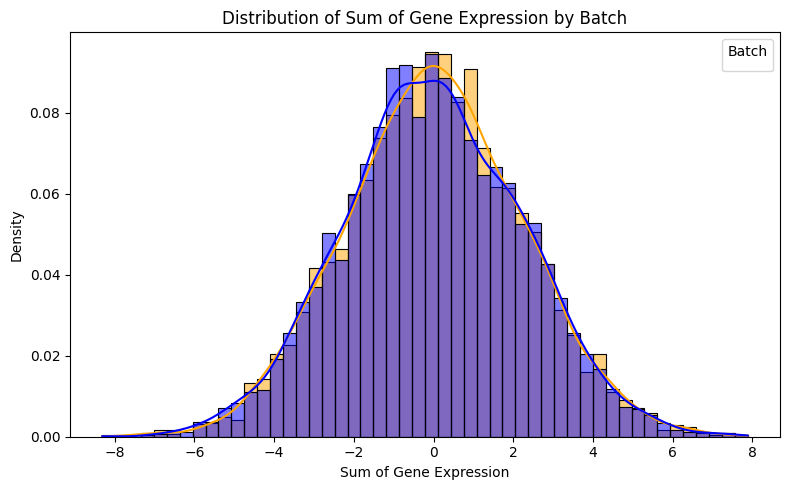

In [101]:
# Convert the sum of gene expression to a pandas DataFrame for plotting
adata.obs["sum_expression"] = adata.X.sum(1)  # Ensure sum_expression is in obs
adata.obs["z"] = adata.obsm["z"].sum(1)
adata.obs["mean"] = adata.obsm["mean"].sum(1)
adata.obs["zinb_sample"] = adata.obsm["zinb_sample"].sum(1)


for key in ["sum_expression", "zinb_sample", "z"]:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=adata.obs, x=key, hue="batch", palette=colors, stat="density", kde=True, bins=50, alpha=0.5)
    plt.xlabel("Sum of Gene Expression")
    plt.ylabel("Density")
    plt.title("Distribution of Sum of Gene Expression by Batch")
    plt.legend(title="Batch")
    plt.tight_layout()
    plt.show()

In [102]:
loss

tensor(3.4054)